# DiscreteBayesNet

GTSAM Copyright 2010-2022, Georgia Tech Research Corporation,
Atlanta, Georgia 30332-0415
All Rights Reserved

Authors: Frank Dellaert, et al. (see THANKS for the full author list)

See LICENSE for the license information

<a href="https://colab.research.google.com/github/borglab/gtsam/blob/develop/gtsam/discrete/doc/DiscreteBayesNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    import google.colab
    %pip install --quiet gtsam
except ImportError:
    pass  # Not running on Colab, do nothing

A `DiscreteBayesNet` is a `BayesNet` of `DiscreteConditional`s. It represents a joint probability distribution over a set of discrete variables as a product of conditional probabilities:
$$
P(X_1, ..., X_n) = \prod_i P(X_i | \text{Parents}(X_i))
$$
Each conditional $P(X_i | \text{Parents}(X_i))$ is a `gtsam.DiscreteConditional`.

A `DiscreteBayesNet` is typically obtained by eliminating a `DiscreteFactorGraph`, but it can also be constructed manually.

In [2]:
import gtsam
import numpy as np
import graphviz

from gtsam.symbol_shorthand import C, S, R, W

## Creating a DiscreteBayesNet

We will manually construct the classic "Wet Grass" Bayes Net, which models the relationships between Cloudy, Sprinkler, Rain, and Wet Grass.

In [3]:
# Define keys for the variables (all binary)
Cloudy = (C(0), 2)
Sprinkler = (S(0), 2)
Rain = (R(0), 2)
WetGrass = (W(0), 2)

# Create an empty Bayes Net
dbn = gtsam.DiscreteBayesNet()

# P(WetGrass | Sprinkler, Rain)
# S,R=FF: 1.0/0.0; S,R=FT: 0.1/0.9; S,R=TF: 0.1/0.9; S,R=TT: 0.01/0.99
dbn.add(WetGrass, [Sprinkler, Rain], "1.0/0.0 0.1/0.9 0.1/0.9 0.01/0.99")

# P(Sprinkler | Cloudy)
# C=F: 0.5/0.5, C=T: 0.9/0.1
dbn.add(Sprinkler, [Cloudy], "0.5/0.5 0.9/0.1")

# P(Rain | Cloudy)
# C=F: 0.8/0.2, C=T: 0.2/0.8
dbn.add(Rain, [Cloudy], "0.8/0.2 0.2/0.8")

# P(Cloudy) - a prior
dbn.add(Cloudy, "0.5/0.5")

print("Manually Constructed DiscreteBayesNet:")
dbn.print()

Manually Constructed DiscreteBayesNet:
DiscreteBayesNet
 
size: 4
conditional 0:  P( w0 | s0 r0 ):
 Choice(w0) 
 0 Choice(s0) 
 0 0 Choice(r0) 
 0 0 0 Leaf    1
 0 0 1 Leaf  0.1
 0 1 Choice(r0) 
 0 1 0 Leaf  0.1
 0 1 1 Leaf 0.01
 1 Choice(s0) 
 1 0 Choice(r0) 
 1 0 0 Leaf    0
 1 0 1 Leaf  0.9
 1 1 Choice(r0) 
 1 1 0 Leaf  0.9
 1 1 1 Leaf 0.99

conditional 1:  P( s0 | c0 ):
 Choice(s0) 
 0 Choice(c0) 
 0 0 Leaf  0.5
 0 1 Leaf  0.9
 1 Choice(c0) 
 1 0 Leaf  0.5
 1 1 Leaf  0.1

conditional 2:  P( r0 | c0 ):
 Choice(r0) 
 0 Choice(c0) 
 0 0 Leaf  0.8
 0 1 Leaf  0.2
 1 Choice(c0) 
 1 0 Leaf  0.2
 1 1 Leaf  0.8

conditional 3:  P( c0 ):
 Leaf  0.5



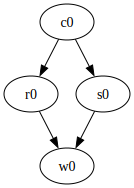

In [4]:
# Visualize the Bayes Net structure
graphviz.Source(dbn.dot())

## Operations on DiscreteBayesNet

In [5]:
# --- Evaluation ---
# Calculate the joint probability of a specific assignment of variables
values = gtsam.DiscreteValues()
values[C(0)] = 1 # Cloudy = T
values[S(0)] = 0 # Sprinkler = F
values[R(0)] = 1 # Rain = T
values[W(0)] = 1 # WetGrass = T

# P(C=T,S=F,R=T,W=T) = P(C=T)*P(S=F|C=T)*P(R=T|C=T)*P(W=T|S=F,R=T)
#                     = 0.5 * 0.9 * 0.8 * 0.9 = 0.324

prob = dbn.evaluate(values)
log_prob = dbn.logProbability(values)
print(f"Joint Probability P(C=T,S=F,R=T,W=T): {prob:.4f}")
print(f"Log Probability: {log_prob:.4f}")

# --- Sampling ---
# Perform ancestral sampling to get a complete assignment.
sample = dbn.sample()
print("\nSampled values:")
print(sample)

# --- Optimization (Finding MPE state) ---
# Finds the most probable explanation (MPE), the assignment with the highest probability.
fg = gtsam.DiscreteFactorGraph(dbn)
mpe_solution = fg.optimize()
print("\nMAP Solution (Optimize):")
print(mpe_solution)

Joint Probability P(C=T,S=F,R=T,W=T): 0.3240
Log Probability: -1.1270

Sampled values:
DiscreteValues{7133701809754865664: 1, 8214565720323784704: 1, 8286623314361712640: 0, 8574853690513424384: 1}

MAP Solution (Optimize):
DiscreteValues{7133701809754865664: 1, 8214565720323784704: 1, 8286623314361712640: 0, 8574853690513424384: 1}


### Displaying with Markdown/HTML
The rich display for a Bayes Net shows the CPT for each conditional.

In [6]:
dbn

DiscreteBayesNet
 
size: 4
conditional 0:  P( w0 | s0 r0 ):
 Choice(w0) 
 0 Choice(s0) 
 0 0 Choice(r0) 
 0 0 0 Leaf    1
 0 0 1 Leaf  0.1
 0 1 Choice(r0) 
 0 1 0 Leaf  0.1
 0 1 1 Leaf 0.01
 1 Choice(s0) 
 1 0 Choice(r0) 
 1 0 0 Leaf    0
 1 0 1 Leaf  0.9
 1 1 Choice(r0) 
 1 1 0 Leaf  0.9
 1 1 1 Leaf 0.99

conditional 1:  P( s0 | c0 ):
 Choice(s0) 
 0 Choice(c0) 
 0 0 Leaf  0.5
 0 1 Leaf  0.9
 1 Choice(c0) 
 1 0 Leaf  0.5
 1 1 Leaf  0.1

conditional 2:  P( r0 | c0 ):
 Choice(r0) 
 0 Choice(c0) 
 0 0 Leaf  0.8
 0 1 Leaf  0.2
 1 Choice(c0) 
 1 0 Leaf  0.2
 1 1 Leaf  0.8

conditional 3:  P( c0 ):
 Leaf  0.5